In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/debug
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


/home/luky/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


## Model Description

This section defines the dynamic system and the measurement model used in experiments:
- State: position and velocity components in 2D.
- Process model: constant-velocity with Gaussian process noise.
- Measurement model: terrain-based elevation reading via interpolated map at the current position.

Note: Coordinates are used in the original map reference frame (no shift).

In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
initial_velocity = torch.from_numpy(initial_velocity_np)

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([ 1.4875e+06,  6.3955e+06,  4.3225e+00, -4.1456e+01])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


## Data Generation

We generate synthetic trajectories and corresponding measurements:
- Number of trajectories and sequence length are configurable.
- Initial state either set to zero or sampled from `Ex0`.
- Measurements are obtained by sampling the elevation map at the trajectory positions.

All prints and comments in the following code are translated to English.

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils

TRAIN_SEQ_LEN = 20
VALID_SEQ_LEN = 20

NUM_TRAIN_TRAJECTORIES = 10000 
NUM_VALID_TRAJECTORIES = 1000 
BATCH_SIZE = 256

system_model.min_x = x_axis_unique.min()
system_model.max_x = x_axis_unique.max()
system_model.min_y = y_axis_unique.min()
system_model.max_y = y_axis_unique.max()
system_model.device = device 

system_model.Ex0 = torch.tensor([(system_model.min_x+system_model.max_x)/2, (system_model.min_y+system_model.max_y)/2, 0.0, 0.0]).float().to(device)


x_train, y_train = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TRAIN_TRAJECTORIES, 
    seq_len=TRAIN_SEQ_LEN,
    force_initial_state_zero=False
)

x_val, y_val = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_VALID_TRAJECTORIES, 
    seq_len=VALID_SEQ_LEN,
    force_initial_state_zero=False
)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


INFO: Data generator uses bounds X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Forced start at zero: False
  Successfully generated trajectory 1000/10000 (Attempts: 1000)
  Successfully generated trajectory 1000/10000 (Attempts: 1000)
  Successfully generated trajectory 2000/10000 (Attempts: 2000)
  Successfully generated trajectory 2000/10000 (Attempts: 2000)
  Successfully generated trajectory 3000/10000 (Attempts: 3000)
  Successfully generated trajectory 3000/10000 (Attempts: 3000)
  Successfully generated trajectory 4000/10000 (Attempts: 4000)
  Successfully generated trajectory 4000/10000 (Attempts: 4000)
  Successfully generated trajectory 5000/10000 (Attempts: 5000)
  Successfully generated trajectory 5000/10000 (Attempts: 5000)
  Successfully generated trajectory 6000/10000 (Attempts: 6000)
  Successfully generated trajectory 6000/10000 (Attempts: 6000)
  Successfully generated trajectory 7000/10000 (Attempts: 7000)
  Successfully generated trajectory 7000/10000 (

## Trajectory and Measurement Visualization

We plot sample trajectories and overlay measurement/elevation information:
- 2D position plots with map boundaries.
- Optional 3D surface or contour views of elevation.
- Legends and axis labels provided in English for clarity.

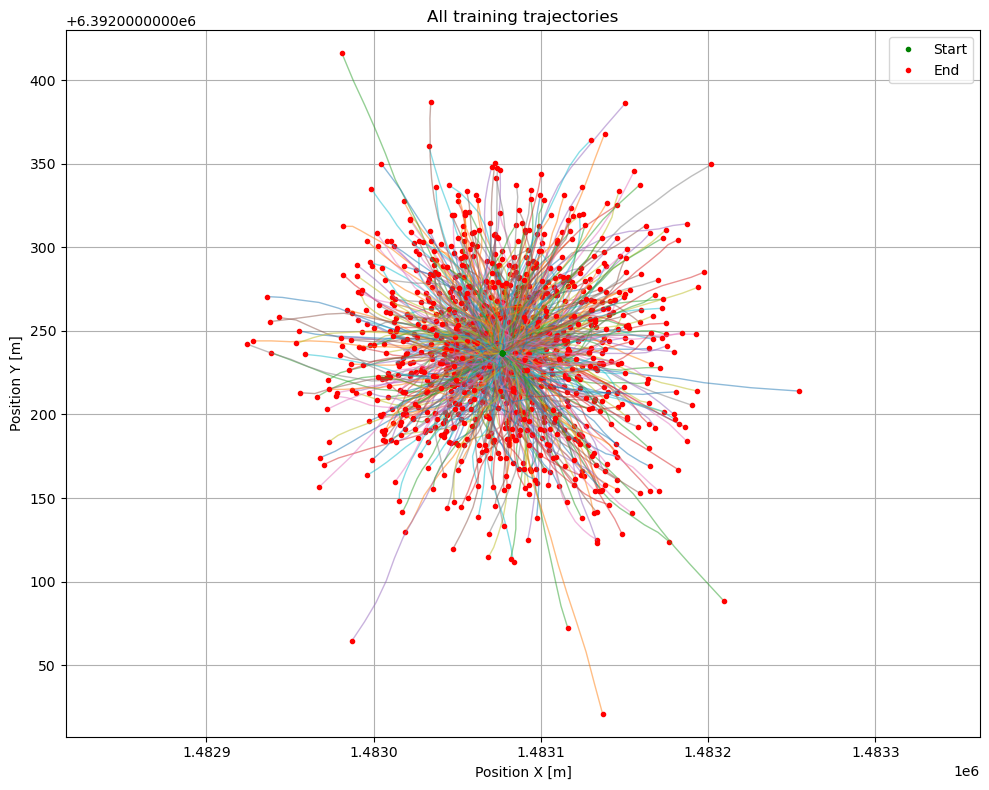

In [6]:
import matplotlib.pyplot as plt

def plot_trajectories(x_data, title="Trajectories", num_to_plot=None):
    x_np = x_data.detach().cpu().numpy()
    
    total_traj = x_np.shape[0]
    
    if num_to_plot is not None and num_to_plot < total_traj:
        indices = np.random.choice(total_traj, num_to_plot, replace=False)
    else:
        indices = range(total_traj)

    plt.figure(figsize=(10, 8))
    
    for i in indices:
        pos_x = x_np[i, :, 0]
        pos_y = x_np[i, :, 1]
        
        plt.plot(pos_x, pos_y, alpha=0.5, linewidth=1)
        
        plt.plot(pos_x[0], pos_y[0], 'go', markersize=3, label='Start' if i == indices[0] else "")
        plt.plot(pos_x[-1], pos_y[-1], 'ro', markersize=3, label='End' if i == indices[0] else "")

    plt.title(title)
    plt.xlabel("Position X [m]")
    plt.ylabel("Position Y [m]")
    plt.grid(True)
    plt.axis('equal')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
plot_trajectories(x_train, title="All training trajectories", num_to_plot=1000)

In [7]:
import torch
import numpy as np

def verify_initialization_hard(system_model, train_loader, val_loader):
    print("Starting strict initialization check...")

    device = torch.device("cpu")
    # Obtain the expected start (map cen
    expected_start = system_model.get_deterministic_initial_state().to(device).detach()

    print(f"Target (Ex0): {expected_start.numpy()}")

    def check_loader(loader, name):
        all_starts = []
        for x, y in loader:
            # x shape: [Batch, Seq, Dim] -> take [:, 0, :]
            starts = x[:, 0, :].to(device)
            all_starts.append(starts)

        all_starts = torch.cat(all_starts, dim=0)  # [N_traj, Dim]

        # 1. Check mean
        mean_start = torch.mean(all_starts, dim=0)

        # 2. Check deviation from target (L2 error norm)
        # Compute difference of each trajectory from Ex0
        diffs = all_starts - expected_start.unsqueeze(0)
        max_diff = torch.max(torch.abs(diffs)).item()

        # 3. Check standard deviation (spread across trajectories)
        std_start = torch.std(all_starts, dim=0)
        max_std = torch.max(std_start).item()

        print(f"\n{name} dataset:")
        print(f"   Mean start: {mean_start.numpy()}")
        print(f"   Max deviation from Ex0: {max_diff:.6f}")
        print(f"   Max standard deviation (Std): {max_std:.6f}")

        # --- HARD ASSERTS ---
        # Tolerance of 1.0 meter (safe for float32 and large map coordinates)
        # If you added the 0.01 noise, this should be well below 1.0.

        if max_diff > 1.0:
            raise ValueError(f"{name} FAILS: Some trajectories do not start at Ex0. Max error: {max_diff}")

        if max_std > 1.0:
            raise ValueError(f"{name} FAILS: Trajectories are inconsistent. Std too large: {max_std}")

        print(f"{name} PASSED.")

    # Check both sets
    check_loader(train_loader, "TRAIN")
    check_loader(val_loader, "VALIDATION")

    print("Initialization mismatch eliminated. All checks passed.")

# --- RUN ONLY AFTER LOADERS ARE CREATED ---
verify_initialization_hard(system_model, train_loader, val_loader)

Starting strict initialization check...
Target (Ex0): [1483076.5 6392237.        0.        0. ]

TRAIN dataset:
   Mean start: [1483076.1 6392239.        0.        0. ]
   Max deviation from Ex0: 0.000000
   Max standard deviation (Std): 0.000000
TRAIN PASSED.

VALIDATION dataset:
   Mean start: [1483076.1 6392238.        0.        0. ]
   Max deviation from Ex0: 0.000000
   Max standard deviation (Std): 0.000000
VALIDATION PASSED.
Initialization mismatch eliminated. All checks passed.


## Training Setup

We train the KalmanNet-based model (`KNet2`) on generated sequences:
- Optimizer and learning rate configured in the next cell.
- Training runs for a fixed number of epochs with validation splits as needed.
- Loss function: Mean Squared Error (MSE) between filtered state estimates and ground-truth states.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import StateKalmanNet 
from state_NN_models import StateKalmanNet_arch2
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if False:
    # Use architecture 2: model with 3 distinct GRU layers
    state_knet2 = StateKalmanNet_arch2(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,
        output_layer_multiplier=4
        ).to(device)
else:
    # Use architecture 1: model with a single GRU layer
    state_knet2 = StateKalmanNet(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=8,
        output_layer_multiplier=4,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=8
        ).to(device)

print(state_knet2)

if False:        
    trained_model = trainer.train_state_KalmanNet_sliding_window(
        model=state_knet2,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=500,
        lr=1e-3,
        clip_grad=10.0,
        early_stopping_patience=200,
        tbptt_k=2,
        tbptt_w=50,
        optimizer_=torch.optim.AdamW,
        weight_decay_=1e-5,
    )

else:
    trained_model = trainer.train_state_KalmanNet(
        model=state_knet2,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=500,
        lr=1e-3,
        clip_grad=10.0,
        early_stopping_patience=50,
        optimizer_type=torch.optim.AdamW,
        weight_decay=1e-4,
    )
    
print(trained_model)

## Following 3 cells are implementation of curriculum learning.

In [9]:
# ==========================================
# PHASE 1: Unit test of dynamics (Seq Len = 5)
# ==========================================
print("Starting PHASE 1: Length 5")

# 1. Data generation (Fixed start at Ex0)
PHASE1_LEN = 5
print(f"Generating data of length {PHASE1_LEN}...")
x_train_1, y_train_1 = utils.generate_data_for_map(system_model, 20000, PHASE1_LEN)
x_val_1, y_val_1 = utils.generate_data_for_map(system_model, 2000, PHASE1_LEN)

train_loader_1 = DataLoader(TensorDataset(x_train_1, y_train_1), batch_size=256, shuffle=True)
val_loader_1 = DataLoader(TensorDataset(x_val_1, y_val_1), batch_size=256, shuffle=False)

# 2. Model initialization 
model_phase1 = StateKalmanNet(
    system_model=system_model,
    device=device,
    hidden_size_multiplier=8,
    output_layer_multiplier=4,
    num_gru_layers=1,
    gru_hidden_dim_multiplier=8
).to(device)


print("Training Phase 1...")
trainer.train_state_KalmanNet(
    model=model_phase1,
    train_loader=train_loader_1,
    val_loader=val_loader_1,
    device=device,
    epochs=50,              # Fewer epochs suffice; convergence should be fast
    lr=1e-3,
    weight_decay=1e-4,      # Light regularization against overfitting
    early_stopping_patience=10
)

# 4. Save weights for the next phase
torch.save(model_phase1.state_dict(), 'knet_phase1.pth')
print("Phase 1 complete. Model saved to 'knet_phase1.pth'.")

Starting PHASE 1: Length 5
Generating data of length 5...
INFO: Data generator uses bounds X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Forced start at zero: False
  Successfully generated trajectory 2000/20000 (Attempts: 2000)
  Successfully generated trajectory 2000/20000 (Attempts: 2000)
  Successfully generated trajectory 4000/20000 (Attempts: 4000)
  Successfully generated trajectory 4000/20000 (Attempts: 4000)
  Successfully generated trajectory 6000/20000 (Attempts: 6000)
  Successfully generated trajectory 6000/20000 (Attempts: 6000)
  Successfully generated trajectory 8000/20000 (Attempts: 8000)
  Successfully generated trajectory 8000/20000 (Attempts: 8000)
  Successfully generated trajectory 10000/20000 (Attempts: 10000)
  Successfully generated trajectory 10000/20000 (Attempts: 10000)
  Successfully generated trajectory 12000/20000 (Attempts: 12000)
  Successfully generated trajectory 12000/20000 (Attempts: 12000)
  Successfully generated trajectory 14000/2000

In [10]:
# ==========================================
# PHASE 2: Extend horizon (Seq Len = 20)
# ==========================================
print("\nStarting PHASE 2: Length 20")

PHASE2_LEN = 20
print(f"Generating data of length {PHASE2_LEN}...")
x_train_2, y_train_2 = utils.generate_data_for_map(system_model, 5000, PHASE2_LEN)
x_val_2, y_val_2 = utils.generate_data_for_map(system_model, 500, PHASE2_LEN)

train_loader_2 = DataLoader(TensorDataset(x_train_2, y_train_2), batch_size=256, shuffle=True)
val_loader_2 = DataLoader(TensorDataset(x_val_2, y_val_2), batch_size=256, shuffle=False)

model_phase2 = StateKalmanNet(
    system_model=system_model,
    device=device,
    hidden_size_multiplier=8,
    output_layer_multiplier=4,
    num_gru_layers=1,
    gru_hidden_dim_multiplier=8
).to(device)

# Load trained weights
model_phase2.load_state_dict(torch.load('knet_phase1.pth'))
print("Weights loaded from Phase 1.")

print("Training Phase 2...")
trainer.train_state_KalmanNet(
    model=model_phase2,
    train_loader=train_loader_2,
    val_loader=val_loader_2,
    device=device,
    epochs=50,
    lr=5e-4,                # Lower LR for fine-tuning
    weight_decay=1e-4,
    early_stopping_patience=10
)

torch.save(model_phase2.state_dict(), 'knet_phase2.pth')
print("Phase 2 complete. Model saved to 'knet_phase2.pth'.")


Starting PHASE 2: Length 20
Generating data of length 20...
INFO: Data generator uses bounds X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Forced start at zero: False
  Successfully generated trajectory 500/5000 (Attempts: 500)
  Successfully generated trajectory 500/5000 (Attempts: 500)
  Successfully generated trajectory 1000/5000 (Attempts: 1000)
  Successfully generated trajectory 1000/5000 (Attempts: 1000)
  Successfully generated trajectory 1500/5000 (Attempts: 1500)
  Successfully generated trajectory 1500/5000 (Attempts: 1500)
  Successfully generated trajectory 2000/5000 (Attempts: 2000)
  Successfully generated trajectory 2000/5000 (Attempts: 2000)
  Successfully generated trajectory 2500/5000 (Attempts: 2500)
  Successfully generated trajectory 2500/5000 (Attempts: 2500)
  Successfully generated trajectory 3000/5000 (Attempts: 3000)
  Successfully generated trajectory 3000/5000 (Attempts: 3000)
  Successfully generated trajectory 3500/5000 (Attempts: 3500)
  Su

In [11]:
# ==========================================
# PHASE 3: Long trajectories + TBPTT (Seq Len = 100)
# ==========================================
print("\nStarting PHASE 3: Length 100 with TBPTT")

# 1. Generate long sequences
PHASE3_LEN = 100
print(f"Generating data of length {PHASE3_LEN}...")
x_train_3, y_train_3 = utils.generate_data_for_map(system_model, 5000, PHASE3_LEN)
x_val_3, y_val_3 = utils.generate_data_for_map(system_model, 1000, PHASE3_LEN)

train_loader_3 = DataLoader(TensorDataset(x_train_3, y_train_3), batch_size=256, shuffle=True)
val_loader_3 = DataLoader(TensorDataset(x_val_3, y_val_3), batch_size=256, shuffle=False)

model_phase3 = StateKalmanNet(
    system_model=system_model,
    device=device,
    hidden_size_multiplier=8,
    output_layer_multiplier=4,
    num_gru_layers=1,
    gru_hidden_dim_multiplier=8
).to(device)

model_phase3.load_state_dict(torch.load('knet_phase2.pth'))
print("Weights loaded from Phase 2.")

# 3. Training with TBPTT (Truncated Backpropagation Through Time)
# k = gradient horizon, w = window shift
print("Training Phase 3 (TBPTT)...")
trainer.train_state_KalmanNet_sliding_window(
    model=model_phase3,
    train_loader=train_loader_3,
    val_loader=val_loader_3,
    device=device,
    epochs=50,
    lr=1e-3,
    clip_grad=1.0,
    early_stopping_patience=10,
    tbptt_k=2,             # Gradient flows 2 steps back
    tbptt_w=8,             # Window shifts by 8 steps
    optimizer_=torch.optim.AdamW,
    weight_decay_=1e-4
)

torch.save(model_phase3.state_dict(), 'knet_final.pth')
print("Complete training finished.")
trained_model = model_phase3


Starting PHASE 3: Length 100 with TBPTT
Generating data of length 100...
INFO: Data generator uses bounds X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Forced start at zero: False
  Successfully generated trajectory 500/5000 (Attempts: 500)
  Successfully generated trajectory 500/5000 (Attempts: 500)
  Successfully generated trajectory 1000/5000 (Attempts: 1000)
  Successfully generated trajectory 1000/5000 (Attempts: 1000)
  Successfully generated trajectory 1500/5000 (Attempts: 1500)
  Successfully generated trajectory 1500/5000 (Attempts: 1500)
  Successfully generated trajectory 2000/5000 (Attempts: 2000)
  Successfully generated trajectory 2000/5000 (Attempts: 2000)
  Successfully generated trajectory 2500/5000 (Attempts: 2500)
  Successfully generated trajectory 2500/5000 (Attempts: 2500)
  Successfully generated trajectory 3000/5000 (Attempts: 3000)
  Successfully generated trajectory 3000/5000 (Attempts: 3000)
  Successfully generated trajectory 3500/5000 (Attempt

## Testing and Evaluation

We evaluate trained and baseline models on held-out test trajectories:
- Metrics: MSE for all, ANEES for model-based filters (when covariance available).
- We report per-trajectory results and final averages across runs.
- Diagnostic plots are included in the next section.

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

state_knet2 = trained_model
TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 10

print(f"\nGenerating {NUM_TEST_TRAJ} test trajectories of length {TEST_SEQ_LEN}...")

x_test, y_test = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ,
    seq_len=TEST_SEQ_LEN,
    force_initial_state_zero=False
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Data generation complete.")

print("y shape:", y_test.shape)  # Should be [N, T, obs_dim]
print("x shape:", x_test.shape)  # Should be [N, T, state_dim]

ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=2000)

all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet2_cpu = []

all_knet_diagnostics_cpu = []
print(f"\nEvaluating models on {NUM_TEST_TRAJ} test trajectories...")

state_knet2.eval()


with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        classic_knet2_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet2.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet2_preds.append(x_filtered_t)
        full_x_hat_classic_knet2 = torch.cat([initial_state, torch.cat(classic_knet2_preds, dim=0)], dim=0)
        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideal model) finished for trajectory {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_classic_knet2_cpu.append(full_x_hat_classic_knet2.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Completed trajectory {i + 1}/{NUM_TEST_TRAJ}...")

mse_ukf_ideal, anees_ukf_ideal = [], []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []
mse_classic_knet2 = []

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat_full, P_hat_full):
            if x_hat_full.shape[0] != x_true.shape[0] or P_hat_full.shape[0] != x_true.shape[0]:
                 raise ValueError(f"Length mismatch! x_true: {x_true.shape[0]}, x_hat: {x_hat_full.shape[0]}, P_hat: {P_hat_full.shape[0]}")

            mse = F.mse_loss(x_hat_full[1:], x_true[1:]).item()

            anees = utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0),
                x_hat_full[1:].unsqueeze(0),
                P_hat_full[1:].unsqueeze(0)
            )
            return mse, anees

        mse = F.mse_loss(all_x_hat_classic_knet2_cpu[i][1:], x_true[1:]).item(); mse_classic_knet2.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
        print("\n" + "="*80)
        print(f"trajectory: {i + 1}/{NUM_TEST_TRAJ}")
        print("="*80)
        print("-" * 80)
        print(f"{'KNet2 (MSE only)':<35} | {(mse_classic_knet2[i]):<20.4f} | {'N/A':<20}")
        print(f"{'UKF (Ideal model)':<35} | {(mse_ukf_ideal[i]):<20.4f} | {(anees_ukf_ideal[i]):<20.4f}")
        print(f"{'PF-SIR (Ideal model)':<35} | {(mse_pf_sir_ideal[i]):<20.4f} | {(anees_pf_sir_ideal[i]):<20.4f}")
        print("="*80)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

print("\n" + "="*80)
print(f"FINAL RESULTS (average over {NUM_TEST_TRAJ} runs)")
print("="*80)
print(f"{'Model':<35} | {'Average MSE':<20} | {'Average ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'KNet2 (MSE only)':<35} | {avg(mse_classic_knet2):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideal model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideal model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)


Generating 10 test trajectories of length 200...
INFO: Data generator uses bounds X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Forced start at zero: False
  Successfully generated trajectory 1/10 (Attempts: 1)
  Successfully generated trajectory 2/10 (Attempts: 2)
  Successfully generated trajectory 3/10 (Attempts: 3)
  Successfully generated trajectory 4/10 (Attempts: 4)
  Successfully generated trajectory 5/10 (Attempts: 5)
  Successfully generated trajectory 6/10 (Attempts: 6)
  Successfully generated trajectory 7/10 (Attempts: 7)
  Successfully generated trajectory 8/10 (Attempts: 8)
  Successfully generated trajectory 9/10 (Attempts: 9)
  Successfully generated trajectory 5/10 (Attempts: 5)
  Successfully generated trajectory 6/10 (Attempts: 6)
  Successfully generated trajectory 7/10 (Attempts: 7)
  Successfully generated trajectory 8/10 (Attempts: 8)
  Successfully generated trajectory 9/10 (Attempts: 9)
  Successfully generated trajectory 10/10 (Attempts: 10)
---

## Diagnostics and Plots

This section visualizes filter estimates, uncertainties, and particle distributions:
- Position/velocity comparisons between ground truth and estimates.
- Covariance-derived uncertainty bands where applicable.
- Particle filter scatter/heatmaps for intuition.

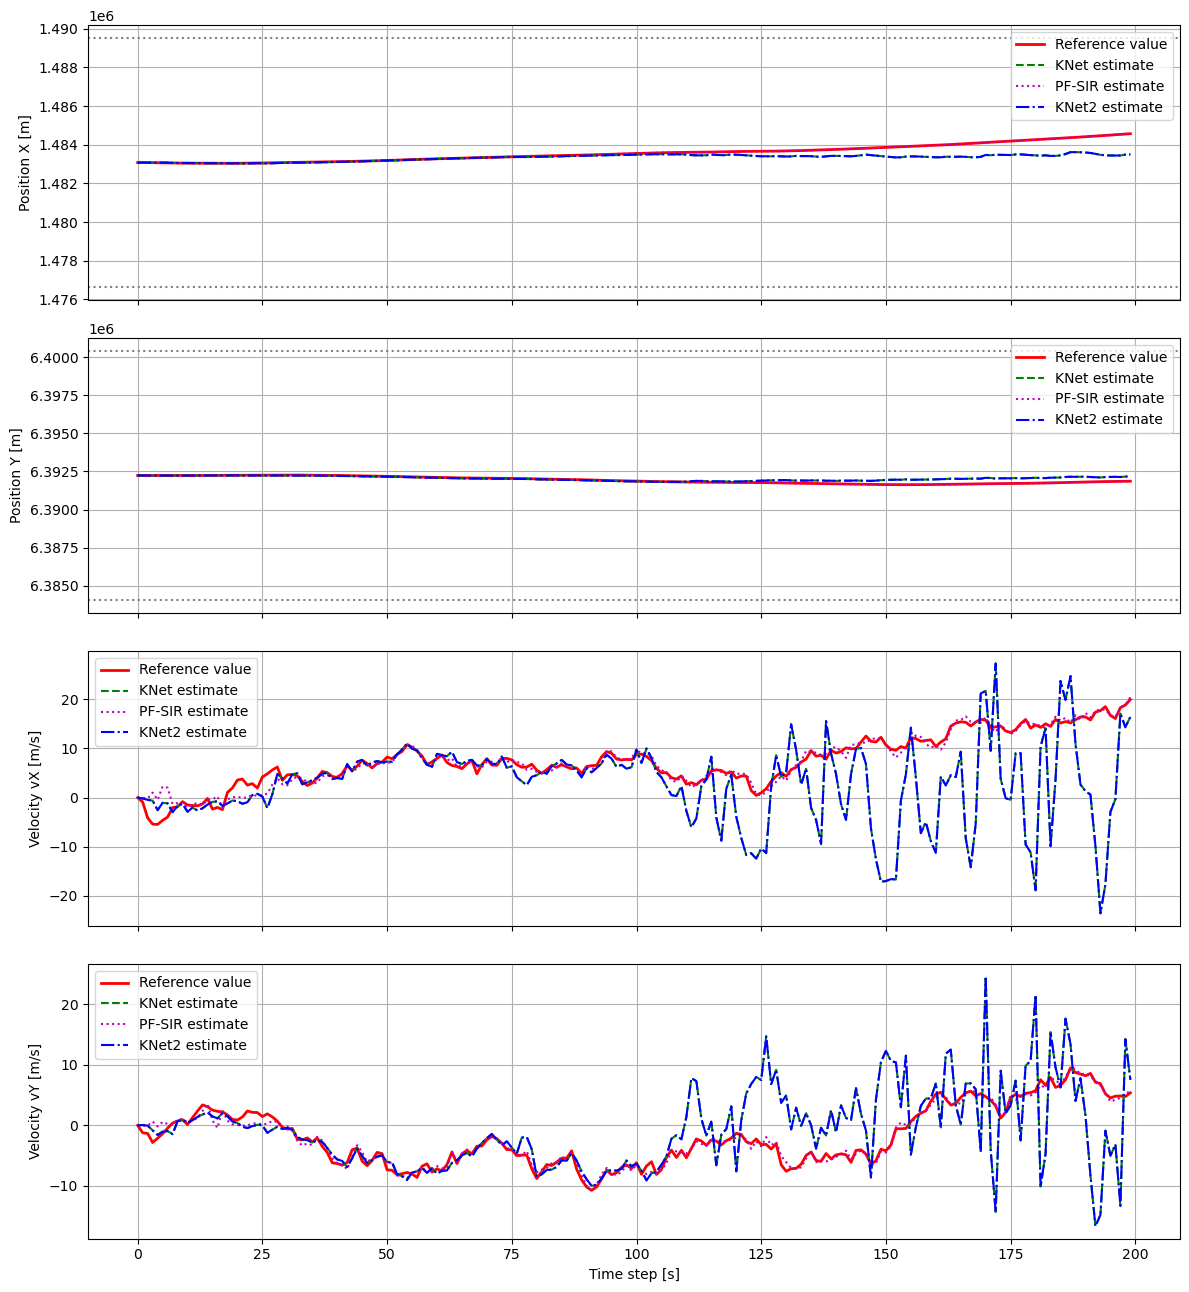

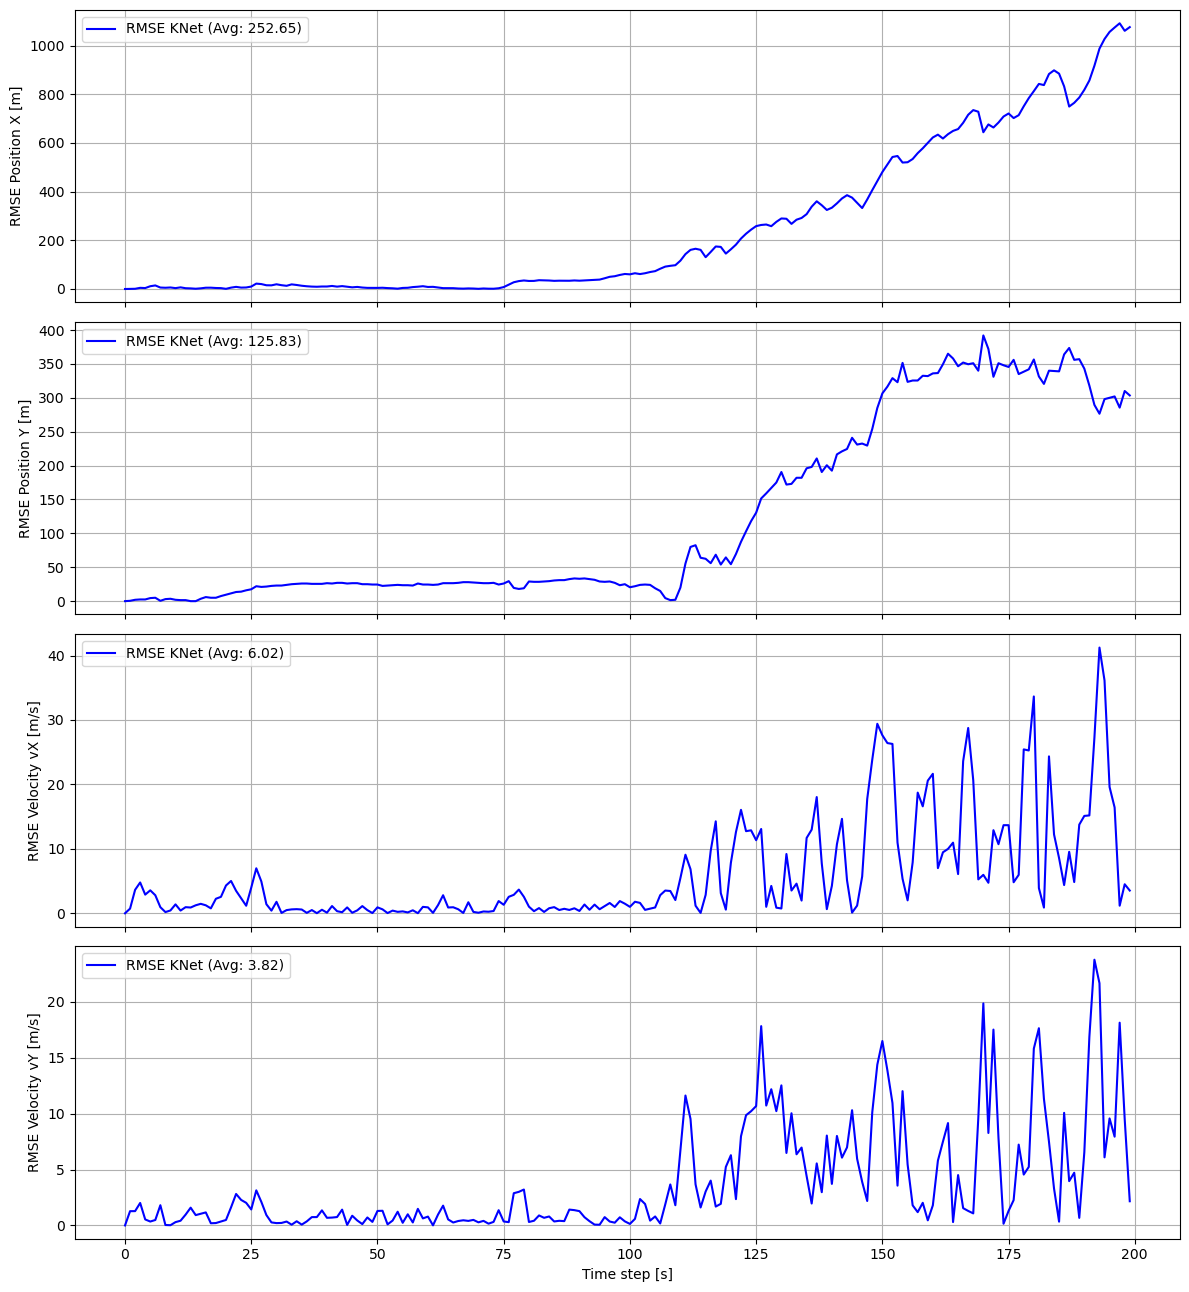

In [16]:
import matplotlib.pyplot as plt

map_bounds = {
    'x_min': 1476611.42,
    'x_max': 1489541.47,
    'y_min': 6384032.63,
    'y_max': 6400441.34
}

index = 1
if index < 0: index = 0
try:
    knet_diagnostics = all_knet_diagnostics_cpu[index]
    plot_diagnostics = True
except (NameError, IndexError):
    plot_diagnostics = False
    plot_gains = False

x_true_plot = all_x_true_cpu[index].numpy()
x_true_tensor = all_x_true_cpu[index]
x_pf_tensor = all_x_hat_pf_sir_ideal_cpu[index]
x_knet2_tensor = all_x_hat_classic_knet2_cpu[index]
x_knet_tensor = x_knet2_tensor
squared_error = (x_knet_tensor - x_true_tensor)**2
rmse_per_step = torch.sqrt(squared_error).numpy()

num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps)
gain_time_axis = np.arange(1, num_steps)

if plot_diagnostics:
    try:
        kalman_gains_history = knet_diagnostics['K_history']
        gains_col0_cpu = [K[0, :, 0].cpu().numpy() for K in kalman_gains_history] 
        gains_col0_np = np.array(gains_col0_cpu)
        plot_gains = True
        
        if gains_col0_np.shape[0] != len(gain_time_axis):
            plot_gains = False
            
    except Exception as e:
        plot_gains = False

    try:
        h_history = knet_diagnostics['h_history']

        h_norms = [torch.norm(h.squeeze(1)).item() for h in h_history] 
        plot_h_norm = True
        
        if len(h_norms) != len(time_axis):
            plot_h_norm = False
            
    except Exception as e:
        plot_h_norm = False

    try:
        innovation_history = knet_diagnostics['innovation_history']
        innov_norms = [torch.norm(innov.squeeze(0)).item() for innov in innovation_history] 
        plot_innov_norm = True
        
        if len(innov_norms) != len(gain_time_axis):
            plot_innov_norm = False
            
    except Exception as e:
        plot_innov_norm = False
        

state_labels = [
    'Position X [m]',
    'Position Y [m]',
    'Velocity vX [m/s]',
    'Velocity vY [m/s]'
]
error_labels = [
    'RMSE Position X [m]',
    'RMSE Position Y [m]',
    'RMSE Velocity vX [m/s]',
    'RMSE Velocity vY [m/s]'
]
gain_labels = [
    'K[0,0] (height -> Position X)',
    'K[1,0] (height -> Position Y)',
    'K[2,0] (height -> Velocity vX)',
    'K[3,0] (height -> Velocity vY)'
]
diagnostic_labels = {
    'h_norm': 'L2 Norm $h_t$',
    'innov_norm': 'L2 Norm $\Delta y_t$'
}


fig1, axes1 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)


fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)


if plot_gains:
    fig3, axes3 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

if plot_diagnostics and plot_h_norm and plot_innov_norm:
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
else:
    plot_h_norm = False
    plot_innov_norm = False



for i in range(4):
    ax1 = axes1[i]
    ax1.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.0, label='Reference value')
    ax1.plot(time_axis, x_knet_tensor[:, i].numpy(), 'g--', linewidth=1.5, label='KNet estimate')
    ax1.plot(time_axis, x_pf_tensor[:, i].numpy(), 'm:', linewidth=1.5, label='PF-SIR estimate')
    ax1.plot(time_axis, x_knet2_tensor[:, i].numpy(), 'b-.', linewidth=1.5, label='KNet2 estimate')
    ax1.set_ylabel(state_labels[i])
    ax1.grid(True)
    ax1.legend()

    if i == 0: 
        ax1.axhline(map_bounds['x_min'], color='grey', linestyle=':', linewidth=1.5, label='Map boundary X')
        ax1.axhline(map_bounds['x_max'], color='grey', linestyle=':', linewidth=1.5)
    elif i == 1: 
        ax1.axhline(map_bounds['y_min'], color='grey', linestyle=':', linewidth=1.5, label='Map boundary Y')
        ax1.axhline(map_bounds['y_max'], color='grey', linestyle=':', linewidth=1.5)
    
    ax2 = axes2[i]
    ax2.plot(time_axis, rmse_per_step[:, i], 'b-', linewidth=1.5, label=f'RMSE KNet (Avg: {np.mean(rmse_per_step[1:, i]):.2f})')
    ax2.set_ylabel(error_labels[i])
    ax2.grid(True)
    ax2.legend()

    if plot_gains:
         ax3 = axes3[i]
         ax3.plot(gain_time_axis, gains_col0_np[:, i], 'k-', linewidth=1.5, label=f'{gain_labels[i]} (Avg: {np.mean(gains_col0_np[:, i]):.4f})')
         ax3.set_ylabel(gain_labels[i])
         ax3.grid(True)
         ax3.legend()

if plot_h_norm:
    ax4_h = axes4[0]
    ax4_h.plot(time_axis, h_norms, 'darkorange', linewidth=1.5, label=f'Norma $h_t$')
    ax4_h.set_ylabel(diagnostic_labels['h_norm'])
    ax4_h.grid(True)
    ax4_h.legend()
    ax4_h.set_yscale('log') 

if plot_innov_norm:
    ax4_innov = axes4[1]
    ax4_innov.plot(gain_time_axis, innov_norms, 'purple', linewidth=1.5, label=f'Norm $\Delta y_t$')
    ax4_innov.set_ylabel(diagnostic_labels['innov_norm'])
    ax4_innov.set_xlabel('Time step [s]')
    ax4_innov.grid(True)
    ax4_innov.legend()
    ax4_innov.set_yscale('log')

axes1[-1].set_xlabel('Time step [s]')
axes2[-1].set_xlabel('Time step [s]')
if plot_gains:
    axes3[-1].set_xlabel('Time step [s]')

fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
fig2.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_gains:
    fig3.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_h_norm or plot_innov_norm:
    fig4.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()